We will start by installing a number of packages that we are going to use throughout this example:

In [ ]:
%%capture
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

# 📄 **Data**

The following code loads the data from an external csv file (prepared locally, on VSCode).

In [ ]:
import pandas as pd

datasets = pd.read_csv('paragraphs.csv')
datasets = datasets.sample(frac = 1)
datasets

,file_name,file_path,source,content,year
10260,2018_MGI-Skill-Shift-Automation-and-future-of-...,texts/txts/tagged/_final\mckinsey\2018_MGI-Ski...,mckinsey,"In general, while the range of required skills...",2018
7124,2022_capgemini_worldpayments_2022.txt,texts/txts/tagged/_final\capgemini\2022_capgem...,capgemini,Build platform versatility to unlock payment ...,2022
3919,2010_capgemini.world_payments_report.2010.txt,texts/txts/tagged/_final\capgemini\2010_capgem...,capgemini,"In recent years, the industry has seen many ne...",2010
2323,2019_BCG-Global-Payments-2019-Tapping-into-Poc...,texts/txts/tagged/_final\bcg\2019_BCG-Global-P...,bcg,• Greater Cross-Border Competition. Cross­bor...,2019
5717,2017_capgemini.world_payments_report.2017.txt,texts/txts/tagged/_final\capgemini\2017_capgem...,capgemini,There are still unanswered questions about the...,2017
...,...,...,...,...,...
1167,2016_Distributed Ledgers in Payments Beyond th...,texts/txts/tagged/_final\bain\2016_Distributed...,bain,Which systems should we be concerned about and...,2016
2859,2020_Five_Strategies_for_Mobile-Payment_Bankin...,texts/txts/tagged/_final\bcg\2020_Five_Strateg...,bcg,Customer Relationship Builder. Go to market un...,2020
5105,2015_capgemini.world_payments_report.2015.txt,texts/txts/tagged/_final\capgemini\2015_capgem...,capgemini,of all stakeholders. Despite the challenges po...,2015
7568,2012_mckinsey.payments.2012.txt,texts/txts/tagged/_final\mckinsey\2012_mckinse...,mckinsey,• Large-scale consumer relationships: A promin...,2012


In [ ]:
datasets['content'] = datasets['content'].astype(str)
texts = datasets['content']
titles = datasets['file_name']

To give you an idea, a text looks like the following:

In [ ]:
# The abstract of "Attention Is All You Need"
print(texts[103])

Guest blogger Mark Quigley discusses what’s driving changes to payments in banking. I needed to write a cheque recently and found myself thinking “How do I do this again!?” Due to my near-total migration to internet and phone banking, what used to be second nature to many people 20 years ago was turning into a bit of a hassle for me: Why I am writing out the numbers in word form? Why do I need to practice my symmetric line drawing to avoid any possible fraud? Where do I even find my cheque book?


In [ ]:
len(texts)

12097

# 🤗 HuggingFace Hub Credentials
Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:


* Create a HuggingFace account [here](https://huggingface.co)
* Apply for Llama 2 access [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)
* Get your HuggingFace token [here](https://huggingface.co/settings/tokens)

After doing so, we can login with our HuggingFace credentials so that this environment knows we have permission to download the Llama 2 model that we are interested in.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# 🦙 **Llama 2**

Now comes one of the more interesting components of this tutorial, how to load in a Llama 2 model on a T4-GPU!

We will be focusing on the `'meta-llama/Llama-2-13b-chat-hf'` variant. It is large enough to give interesting and useful results whilst small enough that it can be run on our environment.

We start by defining our model and identifying if our GPU is correctly selected. We expect the output of `device` to show a cuda device:

In [ ]:
from torch import cuda

model_id = 'meta-llama/Llama-2-13b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


## **Optimization & Quantization**

In order to load our 13 billion parameter model, we will need to perform some optimization tricks. Since we have limited VRAM and not an A100 GPU, we will need to "condense" the model a bit so that we can run it.

There are a number of tricks that we can use but the main principle is going to be 4-bit quantization.

This process reduces the 64-bit representation to only 4-bits which reduces the GPU memory that we will need. It is a recent technique and quite an elegant at that for efficient LLM loading and usage. You can find more about that method [here](https://arxiv.org/pdf/2305.14314.pdf) in the QLoRA paper and on the amazing HuggingFace blog [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [ ]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

These four parameters that we just run are incredibly important and bring many LLM applications to consumers:
* `load_in_4bit`
  * Allows us to load the model in 4-bit precision compared to the original 32-bit precision
  * This gives us an incredibly speed up and reduces memory!
* `bnb_4bit_quant_type`
  * This is the type of 4-bit precision. The paper recommends normalized float 4-bit, so that is what we are going to use!
* `bnb_4bit_use_double_quant`
  * This is a neat trick as it perform a second quantization after the first which further reduces the necessary bits
* `bnb_4bit_compute_dtype`
  * The compute type used during computation, which further speeds up the model.



Using this configuration, we can start loading in the model as well as the tokenizer:

In [ ]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm

Using the model and tokenizer, we will generate a HuggingFace transformers pipeline that allows us to easily generate new text:

In [ ]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

## **Prompt Engineering**

To check whether our model is correctly loaded, let's try it out with a few prompts.

Although we can directly prompt the model, there is actually a template that we need to follow. The template looks as follows:

```python
"""
<s>[INST] <<SYS>>

{{ System Prompt }}

<</SYS>>

{{ User Prompt }} [/INST]

{{ Model Answer }}
"""
```

This template consists of two main components, namely the `{{ System Prompt }}` and the `{{ User Prompt }}`:
* The `{{ System Prompt }}` helps us guide the model during a conversation. For example, we can say that it is a helpful assisant that is specialized in labeling topics.
* The  `{{ User Prompt }}` is where we ask it a question.

You might have noticed the `[INST]` tags, these are used to identify the beginning and end of a prompt. We can use these to model the conversation history as we will see more in-depth later on.

In [ ]:
# special tokens used by llama 2 chat
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

# function to format prompt for general assistant chat
def my_prompt(prompt_str: str):
  return "<s>" + B_INST + B_SYS + """
  You are a helpful, respectful and honest assistant. Always do your best to accurately answer the question provided.

  If you are unsure about an answer, truthfully say 'I don't know'.
  """ + E_SYS + prompt_str + E_INST

# test function
my_prompt("Hello!  How are you?")

"<s>[INST]<<SYS>>\n\n  You are a helpful, respectful and honest assistant. Always do your best to accurately answer the question provided.\n\n  If you are unsure about an answer, truthfully say 'I don't know'.\n  \n<</SYS>>\n\nHello!  How are you?[/INST]"

In [ ]:
prompt1 = my_prompt("Please write a SQL query that obtains the ONLY the fields CUSTOMER_ID and ORDER_ID from the CUSTOMER table and ONLY the fields ORDER_ID and ORDER_TOTAL from the ORDER table.  Then join these together using the ORDER_ID field, group by CUSTOMER_ID and obtain the sum of ORDER_TOTALS.  Then rank by this sum from highest to lowest.")
res = generator(prompt1)
print(res[0]["generated_text"])

<s>[INST]<<SYS>>

  You are a helpful, respectful and honest assistant. Always do your best to accurately answer the question provided.

  If you are unsure about an answer, truthfully say 'I don't know'.
  
<</SYS>>

Please write a SQL query that obtains the ONLY the fields CUSTOMER_ID and ORDER_ID from the CUSTOMER table and ONLY the fields ORDER_ID and ORDER_TOTAL from the ORDER table.  Then join these together using the ORDER_ID field, group by CUSTOMER_ID and obtain the sum of ORDER_TOTALS.  Then rank by this sum from highest to lowest.[/INST]  Sure, I'd be happy to help! Here is the SQL query you requested:
```
SELECT c.CUSTOMER_ID, o.ORDER_ID, SUM(o.ORDER_TOTAL) AS ORDER_TOTAL_SUM
FROM CUSTOMER c
JOIN ORDER o ON c.CUSTOMER_ID = o.CUSTOMER_ID
GROUP BY c.CUSTOMER_ID
ORDER BY ORDER_TOTAL_SUM DESC;
```
Let me explain how this query works:

1. We start by selecting the fields we want from the CUSTOMER and ORDER tables: `c.CUSTOMER_ID` and `o.ORDER_ID` from the CUSTOMER table, and `SU

In [ ]:
prompt2 = my_prompt("Please describe the field of Data Science in the style of a 1920s mobster")
res = generator(prompt2)
print(res[0]["generated_text"])

<s>[INST]<<SYS>>

  You are a helpful, respectful and honest assistant. Always do your best to accurately answer the question provided.

  If you are unsure about an answer, truthfully say 'I don't know'.
  
<</SYS>>

Please describe the field of Data Science in the style of a 1920s mobster[/INST]  Listen up, pal! Data Science, ya hear me? It's like the joint where all the wise guys hang out, ya get me? It's like the speakeasy where the real players come to talk about their numbers, their trends, and their data. It's like the hidden den where the big shots come to make their deals, ya dig?

Now, let me tell ya what's cookin' in this joint. We got these cats called data scientists, see? They're like the brains of the operation, the ones who know how to sift through all the noise and find the good stuff. They're like the wiseguys of the data world, if ya will. They're always lookin' for ways to make the numbers talk, to find patterns and trends that can give 'em the edge they need to mak

In [ ]:
prompt3 = my_prompt("Can you try to prove that there are infinitely many prime numbers?")
res = generator(prompt3)
print(res[0]["generated_text"])

<s>[INST]<<SYS>>

  You are a helpful, respectful and honest assistant. Always do your best to accurately answer the question provided.

  If you are unsure about an answer, truthfully say 'I don't know'.
  
<</SYS>>

Can you try to prove that there are infinitely many prime numbers?[/INST]  Certainly! The proof of the infinitude of prime numbers is a classic result in number theory, and it can be established using a simple but elegant argument. Here's the proof:

Suppose, for the sake of contradiction, that there are only finitely many prime numbers, say $p_1, p_2, \ldots, p_n$. Consider the number $N = (p_1 \cdot p_2 \cdot \ldots \cdot p_n) + 1$. By construction, $N$ is clearly not divisible by any of the prime numbers $p_1, p_2, \ldots, p_n$, since we added 1 to their product. Therefore, $N$ must be either prime or composite.

If $N$ is prime, then it is a new prime number not in the list $p_1, p_2, \ldots, p_n$, which contradicts our assumption that the list is complete.

On the ot

### **Prompt Template for Topic Modeling**

We are going to keep our `system prompt` simple and to the point:

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our `user prompt` is going to the be a bit more involved. It will consist of two components, an **example** and the **main prompt**.

Let's start with the **example**. Most LLMs do a much better job of generating accurate responses if you give them an example to work with. We will show it an accurate example of the kind of output we are expecting.

In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

This example, based on a number of keywords and documents primarily about the impact of
meat, helps to model to understand the kind of output it should give. We show the model that we were expecting only the label, which is easier for us to extract.

Next, we will create a template that we can use within BERTopic:

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [ ]:
prompt = system_prompt + example_prompt + main_prompt

# 🗨️ **BERTopic**

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(texts, show_progress_bar=True)

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.2k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/379 [00:00<?, ?it/s]

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [ ]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(
  vectorizer_model=vectorizer_model,

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(texts, embeddings)


2023-11-23 16:21:18,641 - BERTopic - Reduced dimensionality
2023-11-23 16:21:19,538 - BERTopic - Clustered reduced embeddings
100%|██████████| 68/68 [09:08<00:00,  8.07s/it]


Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,5041,-1_payments_banks_digital_percent,"[payments, banks, digital, percent, services, ...","[firms, banking, companies, business, innovati...",[New Payments Ecosystem: Digital Banking Servi...,"[payments, banks, digital, percent, services, ...",[These BigTech firms are leveraging collaborat...
1,0,535,0_payments_banks_digital_new,"[payments, banks, digital, new, services, mobi...","[banking, liquidity, banks, finance, companies...","[Evolution of Payments and Banking Services, ,...","[payments, banks, digital, new, services, mobi...",[HOW DO EACH OF THESE GROUPS BENEFIT FROM THE...
2,1,385,1_payments_payment_banks_digital,"[payments, payment, banks, digital, cash, cust...","[fintechs, firms, banking, finance, business, ...","[Digital Payment Services in Banking, , , , , ...","[payments, payment, banks, digital, cash, cust...","[As the volume of card usage increases, the av..."
3,2,376,2_payments_market_banks_digital,"[payments, market, banks, digital, services, b...","[fintech, banking, companies, business, banks,...","[Payment industry evolution and innovation, , ...","[payments, market, banks, digital, services, b...",[Digital finance is already giving rise to a r...
4,3,346,3_payments_new_banks_digital,"[payments, new, banks, digital, services, busi...","[innovation, companies, banking, business, tec...","[Future of Payments: Innovation and Growth, , ...","[payments, new, banks, digital, services, busi...",[DIGITAL PAYMENT PLATFORMS ARE LOWERING BARRIE...
...,...,...,...,...,...,...,...,...
63,62,28,62_instant_collar_jobs_sales,"[instant, collar, jobs, sales, schools, public...","[corporates, upselling, digital, multilateral,...","[Evolution of Workforce and Payment Systems, ,...","[instant, collar, jobs, sales, schools, public...",[EC Regulation 924/2009/EC also sets the maxim...
64,63,27,63_intraday_innovation_inputs_manufacturing,"[intraday, innovation, inputs, manufacturing, ...","[industry, liquidity, innovation, exports, for...",[Emerging Economies and Manufacturing Innovati...,"[intraday, innovation, inputs, manufacturing, ...","[In the M-Kopa model, consumers put down a sma..."
65,64,26,64_tpps_pesa_developing_gagement,"[tpps, pesa, developing, gagement, products, b...","[fintechs, diversification, revenues, economie...","[Revenue and cost management for TPPs, , , , ,...","[tpps, pesa, developing, gagement, products, b...","[In addition to efficiency and lower costs, gl..."
66,65,26,65_embedded_data_finance_products,"[embedded, data, finance, products, providers,...","[fintechs, neobanks, banking, underwriters, fi...","[Embedded Finance and Digital Solutions, , , ,...","[embedded, data, finance, products, providers,...",[Apply lightweight technology interventions. B...


In [ ]:
topic_model.get_topic(1, full=True)["Llama2"]

[('Digital Payment Services in Banking', 1),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0)]

We got over 100 topics that were created and they all seem quite diverse.We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF, but we will focus on Llama 2 representations instead.


In [ ]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,5041,-1_payments_banks_digital_percent,New Payments Ecosystem: Digital Banking Services,"[payments, banks, digital, percent, services, ...","[firms, banking, companies, business, innovati...",[New Payments Ecosystem: Digital Banking Servi...,"[payments, banks, digital, percent, services, ...",[These BigTech firms are leveraging collaborat...
1,0,535,0_payments_banks_digital_new,Evolution of Payments and Banking Services,"[payments, banks, digital, new, services, mobi...","[banking, liquidity, banks, finance, companies...","[Evolution of Payments and Banking Services, ,...","[payments, banks, digital, new, services, mobi...",[HOW DO EACH OF THESE GROUPS BENEFIT FROM THE...
2,1,385,1_payments_payment_banks_digital,Digital Payment Services in Banking,"[payments, payment, banks, digital, cash, cust...","[fintechs, firms, banking, finance, business, ...","[Digital Payment Services in Banking, , , , , ...","[payments, payment, banks, digital, cash, cust...","[As the volume of card usage increases, the av..."
3,2,376,2_payments_market_banks_digital,Payment industry evolution and innovation,"[payments, market, banks, digital, services, b...","[fintech, banking, companies, business, banks,...","[Payment industry evolution and innovation, , ...","[payments, market, banks, digital, services, b...",[Digital finance is already giving rise to a r...
4,3,346,3_payments_new_banks_digital,Future of Payments: Innovation and Growth,"[payments, new, banks, digital, services, busi...","[innovation, companies, banking, business, tec...","[Future of Payments: Innovation and Growth, , ...","[payments, new, banks, digital, services, busi...",[DIGITAL PAYMENT PLATFORMS ARE LOWERING BARRIE...
...,...,...,...,...,...,...,...,...,...
63,62,28,62_instant_collar_jobs_sales,Evolution of Workforce and Payment Systems,"[instant, collar, jobs, sales, schools, public...","[corporates, upselling, digital, multilateral,...","[Evolution of Workforce and Payment Systems, ,...","[instant, collar, jobs, sales, schools, public...",[EC Regulation 924/2009/EC also sets the maxim...
64,63,27,63_intraday_innovation_inputs_manufacturing,Emerging Economies and Manufacturing Innovations,"[intraday, innovation, inputs, manufacturing, ...","[industry, liquidity, innovation, exports, for...",[Emerging Economies and Manufacturing Innovati...,"[intraday, innovation, inputs, manufacturing, ...","[In the M-Kopa model, consumers put down a sma..."
65,64,26,64_tpps_pesa_developing_gagement,Revenue and cost management for TPPs,"[tpps, pesa, developing, gagement, products, b...","[fintechs, diversification, revenues, economie...","[Revenue and cost management for TPPs, , , , ,...","[tpps, pesa, developing, gagement, products, b...","[In addition to efficiency and lower costs, gl..."
66,65,26,65_embedded_data_finance_products,Embedded Finance and Digital Solutions,"[embedded, data, finance, products, providers,...","[fintechs, neobanks, banking, underwriters, fi...","[Embedded Finance and Digital Solutions, , , ,...","[embedded, data, finance, products, providers,...",[Apply lightweight technology interventions. B...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_topic_model = topic_model.get_topic_info()
df_topic_model.to_csv('/content/drive/My Drive/2023-11-23_topics.csv')

Mounted at /content/drive


In [ ]:
df_verify = pd.read_csv('/content/drive/My Drive/2023-11-23_topics.csv')
print(df_verify)

    Unnamed: 0  Topic  Count                                         Name  \
0            0     -1   5041            -1_payments_banks_digital_percent   
1            1      0    535                 0_payments_banks_digital_new   
2            2      1    385             1_payments_payment_banks_digital   
3            3      2    376              2_payments_market_banks_digital   
4            4      3    346                 3_payments_new_banks_digital   
..         ...    ...    ...                                          ...   
63          63     62     28                 62_instant_collar_jobs_sales   
64          64     63     27  63_intraday_innovation_inputs_manufacturing   
65          65     64     26             64_tpps_pesa_developing_gagement   
66          66     65     26            65_embedded_data_finance_products   
67          67     66     26              66_corridor_economy_cbdc_skills   

                                          CustomName  \
0   New Payments Ec

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [ ]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

import plotly.io as pio
# Generate the visualization
fig_documents = topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)
# Save as HTML
pio.write_html(fig_documents, file='/content/drive/My Drive/2023-11-23_fig_documents.html')

In [ ]:
topic_model.visualize_topics()
# Generate the visualization
fig_topics = topic_model.visualize_topics()
# Save as HTML
pio.write_html(fig_topics, file='/content/drive/My Drive/2023-11-23_fig_topics.html')

In [ ]:
topic_model.visualize_heatmap()
# Generate the visualization
fig_heatmap = topic_model.visualize_heatmap()
# Save as HTML
pio.write_html(fig_heatmap, file='/content/drive/My Drive/2023-11-23_fig_heatmap.html')

In [ ]:
topic_model.visualize_barchart()
# Generate the visualization
fig_barchart = topic_model.visualize_barchart()
# Save as HTML
pio.write_html(fig_barchart, file='/content/drive/My Drive/2023-11-23_fig_barchart.html')

# 🖼️ (BONUS): **Advanced Visualization**

Although we can use the built-in visualization features of BERTopic, we can also create a static visualization that might be a bit more informative.

We start by creating the necessary variables that contain our reduced embeddings and representations:

In [ ]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in texts]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

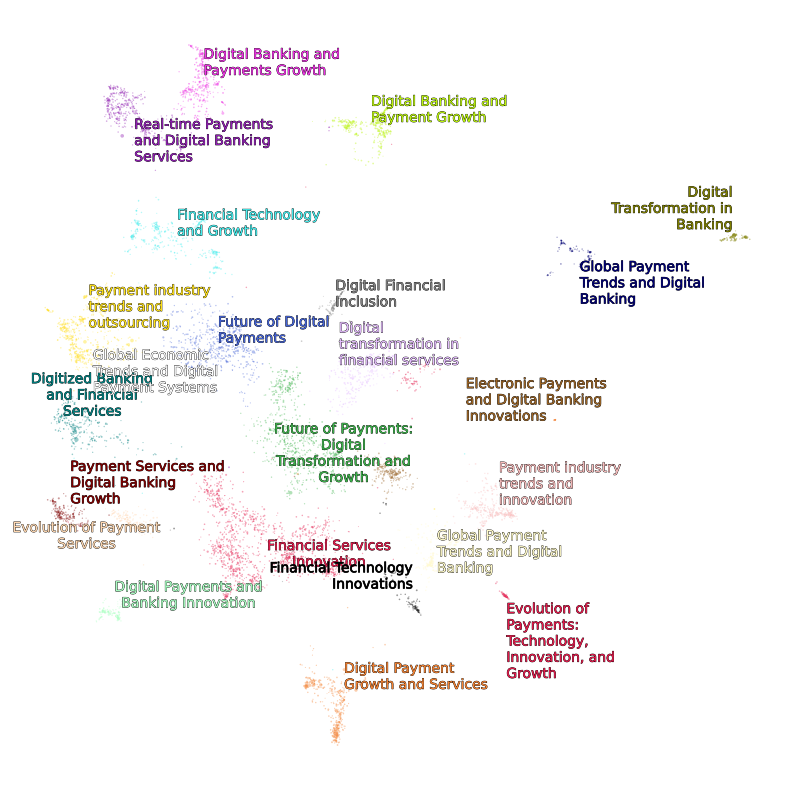

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                          ))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.savefig('advanced-visualisation.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.savefig(fname, *, dpi='figure', format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None, **kwargs
       )

SyntaxError: ignored

# Backup Saving

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# To save: model, reduced embeddings, representative docs
!pip install safetensors

In [ ]:
import pickle

with open('rep_docs.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('reduced_embeddings.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
embedding_model = "BAAI/bge-small-en"
topic_model.save("final", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
!zip -r /content/llama2.zip /content/final

  adding: content/final/ (stored 0%)
  adding: content/final/ctfidf.safetensors (deflated 58%)
  adding: content/final/config.json (deflated 38%)
  adding: content/final/ctfidf_config.json (deflated 66%)
  adding: content/final/topics.json (deflated 89%)
  adding: content/final/topic_embeddings.safetensors (deflated 7%)


In [ ]:
!jupyter nbconvert --to markdown Topic_Modeling_with_Llama2.ipynb

[NbConvertApp] WARNING | pattern 'Topic_Modeling_with_Llama2.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True